In [6]:
# %pip install numpy
# %pip install pandas
# %pip install scikit-learn
# %pip install tensorflow
# %pip install scikeras
# %pip install matplotlib

In [ ]:
# Step 1: Set Up Environment
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress warnings
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "1"
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "1"

import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#  Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- Load Data ---
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train["label"] = train["label"].astype(int)
X = train.drop(columns=["label"])
y = train["label"]

#  Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

#  Split Data: 90% Train, 10% Validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=42)

# --- 1) Define the Model with Hyperparameter Tuning ---
def build_higgs_model(hp):
    model = Sequential()
    model.add(Input(shape=(28,)))  # 28 features

    # Tune number of hidden layers (between 2 and 8)
    num_layers = hp.Int("num_layers", 2, 8)
    
    for _ in range(num_layers):
        # Tune number of neurons per layer (100-500)
        units = hp.Int("units", min_value=100, max_value=500, step=50)
        model.add(Dense(units, kernel_regularizer=tf.keras.regularizers.l2(hp.Choice("l2", [1e-5, 1e-4, 5e-4, 1e-3]))))
        model.add(BatchNormalization())

        # Tune activation function (LeakyReLU or Swish)
        activation = hp.Choice("activation", ["leaky_relu", "swish", "tanh"])
        if activation == "leaky_relu":
            model.add(LeakyReLU(alpha=0.1))
        elif activation == "swish":
            model.add(tf.keras.layers.Activation("swish"))
        else:  # activation == "tanh"
            model.add(tf.keras.layers.Activation("tanh"))

        # Tune dropout rate (0.2 - 0.6)
        model.add(Dropout(hp.Float("dropout", 0.2, 0.6, step=0.05)))

    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Tune optimizer (Adam, RMSprop, SGD)
    optimizer_name = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    learning_rate = hp.Choice("learning_rate", [0.0005, 0.001, 0.002, 0.003, 0.005])
    
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer_name == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    return model

# --- 2) Setup Hyperparameter Tuning with Bayesian Optimization ---
tuner = kt.BayesianOptimization(
    build_higgs_model,
    objective="val_AUC",
    max_trials=50,  # Increase search space
    executions_per_trial=1,
    directory="higgs_tuning_1",
    project_name="higgs_optimization",
)

#  Early Stopping & LR Reduction
early_stopping = EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True, mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=5, verbose=1, mode='max')

#  Run the Tuning Process
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Reduce epochs per run
    batch_size=128,  #  Default batch size (will be tuned later)
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

Trial 50 Complete [00h 05m 21s]
val_AUC: 0.7912253141403198

Best val_AUC So Far: 0.8005800843238831
Total elapsed time: 04h 19m 08s


Best Hyperparameters: {'num_layers': 5, 'units': 100, 'l2': 1e-05, 'activation': 'swish', 'dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.002}
Best Batch Size: 128
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.6041 - loss: 0.6954 - val_AUC: 0.7322 - val_loss: 0.6083 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7109 - loss: 0.6255 - val_AUC: 0.7531 - val_loss: 0.5895 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7373 - loss: 0.6063 - val_AUC: 0.7609 - val_loss: 0.5825 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7487 - loss: 0.5963 - val_AUC: 0.7680 - val_loss: 0.5764 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7568 - loss: 0.5895 - val_AUC: 0.7710 - val_loss: 0.5742 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7610 - loss: 0.5865 - val_AUC: 0.7749 - val_loss

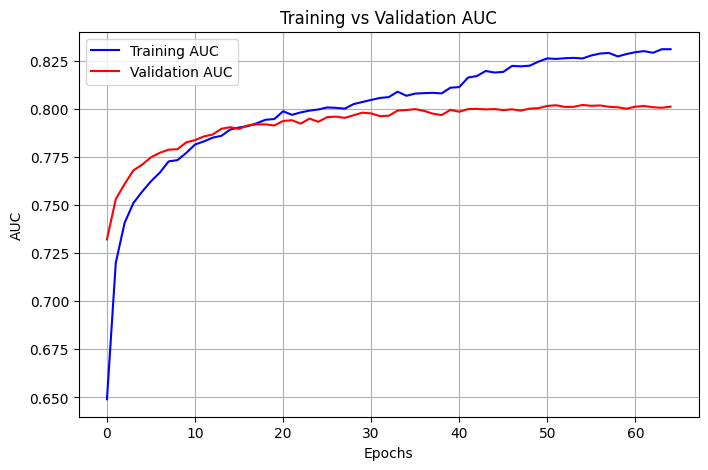

In [12]:
#  Retrieve Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_batch_size = best_hps.values.get("batch_size", 128)  #  Get best batch size (default to 128 if missing)

print(f"Best Hyperparameters: {best_hps.values}")
print(f"Best Batch Size: {best_batch_size}")

#  Train the Best Model on Full Data (Using the Tuned Batch Size)
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Train longer
    batch_size=best_batch_size,  #  Now using the best batch size
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

#  Plot Training vs Validation AUC
plt.figure(figsize=(8, 5))
plt.plot(history.history['AUC'], label='Training AUC', color='blue')
plt.plot(history.history['val_AUC'], label='Validation AUC', color='red')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Step 2: Train Multiple Models with the Top 5 Best Hyperparameters and Different Seeds
num_hyperparams = 5  # Number of top hyperparameter configurations
models_per_hyperparam = 4  # Number of models per hyperparameter set
total_models = num_hyperparams * models_per_hyperparam  # Total models to train

#  Retrieve the top 5 best hyperparameters
best_hyperparams_list = tuner.get_best_hyperparameters(num_trials=num_hyperparams)

model_paths = []
model_index = 1  # Model naming index

for hp_index, best_hps in enumerate(best_hyperparams_list):
    for seed_index in range(models_per_hyperparam):
        print(f"🔹 Training Model {model_index}/{total_models} | HP Config {hp_index+1} | Seed {seed_index*100}")

        #  Set different random seed per model
        tf.random.set_seed(seed_index * 100)
        np.random.seed(seed_index * 100)

        #  Build and Train Model with the Selected Hyperparameters
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,  # Train longer
            batch_size = best_hps.values.get("batch_size", 128),
            verbose=1,
            callbacks=[early_stopping, lr_scheduler]
        )

        #  Save Model
        model_path = f"best_model_{model_index}.h5"
        model.save(model_path)
        model_paths.append(model_path)

        model_index += 1  # Increment model index

print(" All models trained and saved for ensembling!")

🔹 Training Model 1/20 | HP Config 1 | Seed 0
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6162 - loss: 0.6862 - val_AUC: 0.7119 - val_loss: 0.6256 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7090 - loss: 0.6263 - val_AUC: 0.7367 - val_loss: 0.6037 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7370 - loss: 0.6060 - val_AUC: 0.7527 - val_loss: 0.5898 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7460 - loss: 0.5981 - val_AUC: 0.7593 - val_loss: 0.5836 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7550 - loss: 0.5910 - val_AUC: 0.7684 - val_loss: 0.5759 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7612 - loss: 0.5845 - val_AUC: 0.7708 - val_loss: 0.5741 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7663 - loss: 0.5803 - val_AUC: 0.77

🔹 Training Model 2/20 | HP Config 1 | Seed 100
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6043 - loss: 0.6975 - val_AUC: 0.7208 - val_loss: 0.6268 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7083 - loss: 0.6276 - val_AUC: 0.7466 - val_loss: 0.5975 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7339 - loss: 0.6086 - val_AUC: 0.7581 - val_loss: 0.5858 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7463 - loss: 0.5980 - val_AUC: 0.7651 - val_loss: 0.5787 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7552 - loss: 0.5909 - val_AUC: 0.7716 - val_loss: 0.5730 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7608 - loss: 0.5857 - val_AUC: 0.7764 - val_loss: 0.5691 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7674 - loss: 0.5795 - val_AUC: 0.

🔹 Training Model 3/20 | HP Config 1 | Seed 200
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6106 - loss: 0.6902 - val_AUC: 0.7297 - val_loss: 0.6165 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7101 - loss: 0.6270 - val_AUC: 0.7507 - val_loss: 0.5917 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7344 - loss: 0.6089 - val_AUC: 0.7570 - val_loss: 0.5857 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7477 - loss: 0.5969 - val_AUC: 0.7676 - val_loss: 0.5771 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7546 - loss: 0.5909 - val_AUC: 0.7713 - val_loss: 0.5742 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7607 - loss: 0.5861 - val_AUC: 0.7745 - val_loss: 0.5718 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7657 - loss: 0.5816 - val_AUC: 0.

🔹 Training Model 4/20 | HP Config 1 | Seed 300
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6169 - loss: 0.6869 - val_AUC: 0.7232 - val_loss: 0.6183 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7136 - loss: 0.6230 - val_AUC: 0.7448 - val_loss: 0.5991 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7382 - loss: 0.6052 - val_AUC: 0.7571 - val_loss: 0.5867 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7537 - loss: 0.5927 - val_AUC: 0.7648 - val_loss: 0.5803 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7594 - loss: 0.5869 - val_AUC: 0.7695 - val_loss: 0.5753 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7695 - loss: 0.5784 - val_AUC: 0.7730 - val_loss: 0.5737 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7710 - loss: 0.5768 - val_AUC: 0.

🔹 Training Model 5/20 | HP Config 2 | Seed 0
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.5744 - loss: 0.7334 - val_AUC: 0.6989 - val_loss: 0.6390 - learning_rate: 5.0000e-04
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6599 - loss: 0.6659 - val_AUC: 0.7218 - val_loss: 0.6220 - learning_rate: 5.0000e-04
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6943 - loss: 0.6432 - val_AUC: 0.7355 - val_loss: 0.6105 - learning_rate: 5.0000e-04
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7122 - loss: 0.6279 - val_AUC: 0.7419 - val_loss: 0.6042 - learning_rate: 5.0000e-04
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7269 - loss: 0.6183 - val_AUC: 0.7491 - val_loss: 0.5977 - learning_rate: 5.0000e-04
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7314 - loss: 0.6139 - val_AUC: 0.7548 - val_loss: 0.5929 - learning_rate: 5.0000e-04
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7431 - loss

🔹 Training Model 6/20 | HP Config 2 | Seed 100
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.5681 - loss: 0.7316 - val_AUC: 0.6979 - val_loss: 0.6418 - learning_rate: 5.0000e-04
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6541 - loss: 0.6676 - val_AUC: 0.7198 - val_loss: 0.6217 - learning_rate: 5.0000e-04
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6925 - loss: 0.6426 - val_AUC: 0.7339 - val_loss: 0.6117 - learning_rate: 5.0000e-04
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7104 - loss: 0.6296 - val_AUC: 0.7431 - val_loss: 0.6041 - learning_rate: 5.0000e-04
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7288 - loss: 0.6165 - val_AUC: 0.7510 - val_loss: 0.5963 - learning_rate: 5.0000e-04
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7373 - loss: 0.6096 - val_AUC: 0.7578 - val_loss: 0.5896 - learning_rate: 5.0000e-04
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7434 - lo

🔹 Training Model 7/20 | HP Config 2 | Seed 200
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5669 - loss: 0.7297 - val_AUC: 0.7010 - val_loss: 0.6358 - learning_rate: 5.0000e-04
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6522 - loss: 0.6702 - val_AUC: 0.7232 - val_loss: 0.6219 - learning_rate: 5.0000e-04
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6873 - loss: 0.6463 - val_AUC: 0.7364 - val_loss: 0.6102 - learning_rate: 5.0000e-04
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7118 - loss: 0.6304 - val_AUC: 0.7443 - val_loss: 0.6035 - learning_rate: 5.0000e-04
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7203 - loss: 0.6236 - val_AUC: 0.7516 - val_loss: 0.5959 - learning_rate: 5.0000e-04
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7303 - loss: 0.6158 - val_AUC: 0.7574 - val_loss: 0.5910 - learning_rate: 5.0000e-04
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7430 - lo

🔹 Training Model 8/20 | HP Config 2 | Seed 300
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5808 - loss: 0.7274 - val_AUC: 0.6994 - val_loss: 0.6363 - learning_rate: 5.0000e-04
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6627 - loss: 0.6620 - val_AUC: 0.7223 - val_loss: 0.6199 - learning_rate: 5.0000e-04
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6987 - loss: 0.6391 - val_AUC: 0.7357 - val_loss: 0.6106 - learning_rate: 5.0000e-04
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7132 - loss: 0.6287 - val_AUC: 0.7443 - val_loss: 0.6025 - learning_rate: 5.0000e-04
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7299 - loss: 0.6156 - val_AUC: 0.7508 - val_loss: 0.5957 - learning_rate: 5.0000e-04
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7373 - loss: 0.6092 - val_AUC: 0.7543 - val_loss: 0.5928 - learning_rate: 5.0000e-04
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7424 - lo

🔹 Training Model 9/20 | HP Config 3 | Seed 0
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6216 - loss: 0.7226 - val_AUC: 0.7044 - val_loss: 0.6466 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7211 - loss: 0.6316 - val_AUC: 0.7379 - val_loss: 0.6174 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7440 - loss: 0.6134 - val_AUC: 0.7396 - val_loss: 0.6133 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7551 - loss: 0.6035 - val_AUC: 0.7651 - val_loss: 0.5934 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.7635 - loss: 0.5962 - val_AUC: 0.7693 - val_loss: 0.5942 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.7664 - loss: 0.5929 - val_AUC: 0.7755 - val_loss: 0.5851 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7721 - loss: 0.5869 - val_AUC: 0.

🔹 Training Model 10/20 | HP Config 3 | Seed 100
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6247 - loss: 0.7138 - val_AUC: 0.7414 - val_loss: 0.6438 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.7230 - loss: 0.6327 - val_AUC: 0.7547 - val_loss: 0.6051 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7418 - loss: 0.6162 - val_AUC: 0.7635 - val_loss: 0.5923 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.7536 - loss: 0.6065 - val_AUC: 0.7698 - val_loss: 0.5865 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7598 - loss: 0.6000 - val_AUC: 0.7726 - val_loss: 0.5828 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7665 - loss: 0.5928 - val_AUC: 0.7769 - val_loss: 0.5781 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7703 - loss: 0.5894 - val_AUC:

🔹 Training Model 11/20 | HP Config 3 | Seed 200
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.6170 - loss: 0.7242 - val_AUC: 0.7316 - val_loss: 0.6264 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7192 - loss: 0.6353 - val_AUC: 0.7511 - val_loss: 0.6042 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7417 - loss: 0.6158 - val_AUC: 0.7605 - val_loss: 0.5958 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7547 - loss: 0.6045 - val_AUC: 0.7680 - val_loss: 0.5886 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7588 - loss: 0.6004 - val_AUC: 0.7707 - val_loss: 0.5880 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7634 - loss: 0.5954 - val_AUC: 0.7762 - val_loss: 0.5825 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7687 - loss: 0.5897 - val_AUC: 0

🔹 Training Model 12/20 | HP Config 3 | Seed 300
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.6251 - loss: 0.7119 - val_AUC: 0.7204 - val_loss: 0.6379 - learning_rate: 0.0020
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.7241 - loss: 0.6311 - val_AUC: 0.7474 - val_loss: 0.6080 - learning_rate: 0.0020
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.7479 - loss: 0.6108 - val_AUC: 0.7539 - val_loss: 0.6027 - learning_rate: 0.0020
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.7574 - loss: 0.6019 - val_AUC: 0.7613 - val_loss: 0.5946 - learning_rate: 0.0020
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - AUC: 0.7631 - loss: 0.5964 - val_AUC: 0.7662 - val_loss: 0.5907 - learning_rate: 0.0020
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.7680 - loss: 0.5916 - val_AUC: 0.7707 - val_loss: 0.5856 - learning_rate: 0.0020
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - AUC: 0.7723 - loss: 0.5878 - val_

🔹 Training Model 13/20 | HP Config 4 | Seed 0
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.5496 - loss: 0.7446 - val_AUC: 0.6887 - val_loss: 0.6505 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6615 - loss: 0.6655 - val_AUC: 0.7199 - val_loss: 0.6326 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6980 - loss: 0.6427 - val_AUC: 0.7351 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7127 - loss: 0.6318 - val_AUC: 0.7463 - val_loss: 0.6116 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7284 - loss: 0.6212 - val_AUC: 0.7543 - val_loss: 0.6005 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7383 - loss: 0.6124 - val_AUC: 0.7571 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7465 - loss: 0.6056 - val_AUC: 0.7

🔹 Training Model 14/20 | HP Config 4 | Seed 100
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.5531 - loss: 0.7400 - val_AUC: 0.7030 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6622 - loss: 0.6644 - val_AUC: 0.7279 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6927 - loss: 0.6445 - val_AUC: 0.7364 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7125 - loss: 0.6324 - val_AUC: 0.7464 - val_loss: 0.6064 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7305 - loss: 0.6187 - val_AUC: 0.7545 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7367 - loss: 0.6140 - val_AUC: 0.7587 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7459 - loss: 0.6068 - val_AUC: 0

🔹 Training Model 15/20 | HP Config 4 | Seed 200
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.5344 - loss: 0.7577 - val_AUC: 0.6994 - val_loss: 0.6509 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6515 - loss: 0.6710 - val_AUC: 0.7232 - val_loss: 0.6279 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6908 - loss: 0.6479 - val_AUC: 0.7347 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7078 - loss: 0.6364 - val_AUC: 0.7440 - val_loss: 0.6075 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7220 - loss: 0.6266 - val_AUC: 0.7533 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7346 - loss: 0.6164 - val_AUC: 0.7603 - val_loss: 0.5925 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7421 - loss: 0.6097 - val_AUC: 0

🔹 Training Model 16/20 | HP Config 4 | Seed 300
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.5443 - loss: 0.7455 - val_AUC: 0.6973 - val_loss: 0.6482 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6675 - loss: 0.6609 - val_AUC: 0.7227 - val_loss: 0.6275 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7021 - loss: 0.6399 - val_AUC: 0.7364 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.7189 - loss: 0.6285 - val_AUC: 0.7436 - val_loss: 0.6092 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7300 - loss: 0.6202 - val_AUC: 0.7521 - val_loss: 0.6003 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7391 - loss: 0.6130 - val_AUC: 0.7567 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7498 - loss: 0.6034 - val_AUC: 0

🔹 Training Model 17/20 | HP Config 5 | Seed 0
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5936 - loss: 0.7222 - val_AUC: 0.6446 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6624 - loss: 0.6627 - val_AUC: 0.6748 - val_loss: 0.6566 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6953 - loss: 0.6415 - val_AUC: 0.7095 - val_loss: 0.6337 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7168 - loss: 0.6265 - val_AUC: 0.7341 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7358 - loss: 0.6126 - val_AUC: 0.7497 - val_loss: 0.6013 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7477 - loss: 0.6032 - val_AUC: 0.7557 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7543 - loss: 0.5974 - val_AUC: 0.7

🔹 Training Model 18/20 | HP Config 5 | Seed 100
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5897 - loss: 0.7290 - val_AUC: 0.6343 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6539 - loss: 0.6681 - val_AUC: 0.6724 - val_loss: 0.6576 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6871 - loss: 0.6459 - val_AUC: 0.7061 - val_loss: 0.6353 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7034 - loss: 0.6353 - val_AUC: 0.7196 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7241 - loss: 0.6203 - val_AUC: 0.7448 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7398 - loss: 0.6088 - val_AUC: 0.7601 - val_loss: 0.5912 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7532 - loss: 0.5982 - val_AUC: 0

🔹 Training Model 19/20 | HP Config 5 | Seed 200
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5914 - loss: 0.7239 - val_AUC: 0.6629 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6599 - loss: 0.6649 - val_AUC: 0.6925 - val_loss: 0.6490 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6950 - loss: 0.6423 - val_AUC: 0.7131 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7140 - loss: 0.6289 - val_AUC: 0.7356 - val_loss: 0.6170 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7359 - loss: 0.6128 - val_AUC: 0.7482 - val_loss: 0.6040 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7451 - loss: 0.6053 - val_AUC: 0.7606 - val_loss: 0.5918 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7540 - loss: 0.5979 - val_AUC: 0

🔹 Training Model 20/20 | HP Config 5 | Seed 300
Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5945 - loss: 0.7229 - val_AUC: 0.6666 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6626 - loss: 0.6638 - val_AUC: 0.6914 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6877 - loss: 0.6467 - val_AUC: 0.7069 - val_loss: 0.6366 - learning_rate: 0.0010
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7082 - loss: 0.6331 - val_AUC: 0.7183 - val_loss: 0.6307 - learning_rate: 0.0010
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7268 - loss: 0.6200 - val_AUC: 0.7277 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7477 - loss: 0.6034 - val_AUC: 0.7506 - val_loss: 0.6018 - learning_rate: 0.0010
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7556 - loss: 0.5969 - val_AUC: 0

✅ All models trained and saved for ensembling!


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
157/157 ━━━━━━━━

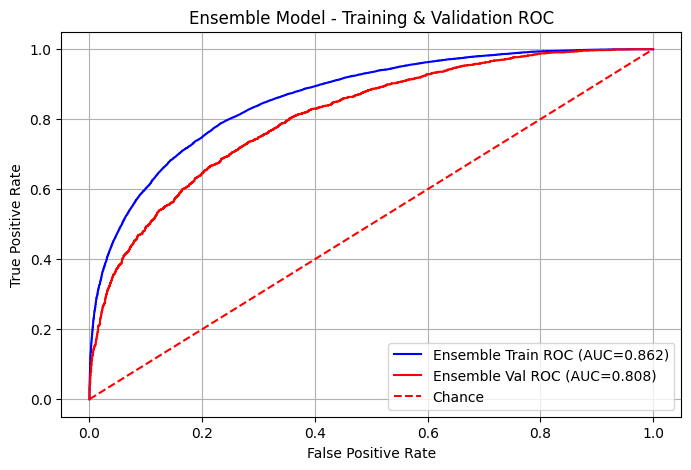

In [ ]:
# Step 3: Ensemble Predictions
from sklearn.metrics import roc_auc_score, roc_curve, auc

#  Load Saved Models
models = [tf.keras.models.load_model(path) for path in model_paths]

#  Generate Predictions from All Models
train_preds = np.array([model.predict(X_scaled)[:, 0] for model in models])
val_preds = np.array([model.predict(X_val)[:, 0] for model in models])
test_preds = np.array([model.predict(test_scaled)[:, 0] for model in models])

# Compute validation AUC for each model
val_aucs = [roc_auc_score(y_val, val_preds[i]) for i in range(len(models))]

# Normalize AUCs to sum to 1 (turn them into weights)
weights = np.array(val_aucs) / np.sum(val_aucs)

# Apply weighted averaging for final predictions (weighted test averaging added)
final_train_probs = np.average(train_preds, axis=0, weights=weights)
final_val_probs = np.average(val_preds, axis=0, weights=weights)  # NEW: Weighted validation averaging
final_test_probs = np.average(test_preds, axis=0, weights=weights)  # NEW: Weighted test averaging

#  Compute AUC on Training Data
train_fpr, train_tpr, _ = roc_curve(y, final_train_probs, pos_label=1)
train_auc = auc(train_fpr, train_tpr)
print(f" Final Ensemble AUC on training set: {train_auc:.4f}")

#  Compute AUC on Validation Data (NEW)
val_auc = roc_auc_score(y_val, final_val_probs)
print(f" Final Ensemble AUC on validation set: {val_auc:.4f}")

#  Predict on Test Set
binary_preds = (final_test_probs >= 0.5).astype(int)

#  Save Submission
submission = np.column_stack((test.index.values, binary_preds))
np.savetxt(
    'sample_submission_higgs_ensemble.csv',
    submission,
    header='Id,Predicted',
    delimiter=',',
    comments='',
    fmt=['%1.18e', '%1.18e']
)

print(" sample_submission_higgs_ensemble.csv saved!")

#  Plot ROC Curve for Ensemble Validation
plt.figure(figsize=(8, 5))
plt.plot(train_fpr, train_tpr, label=f'Ensemble Train ROC (AUC={train_auc:.3f})', color='blue')
val_fpr, val_tpr, _ = roc_curve(y_val, final_val_probs)
plt.plot(val_fpr, val_tpr, label=f'Ensemble Val ROC (AUC={val_auc:.3f})', color='red')
plt.plot([0, 1], [0, 1], 'r--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model - Training & Validation ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()
